In [1]:
#imports
import pandas as pd
import numpy as np
import sys
import sklearn
import io
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score,recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from __future__ import annotations
from sklearn.model_selection import train_test_split

from typing import Callable


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
#contains 43 feature
column_names = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land',
    'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
    'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
    'num_access_files', 'num_outbound_cmds', 'is_hot_login', 'is_guest_login', 'count',
    'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate',
    'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
    'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
    'dst_host_rerror_rate', 'dst_host_srv_serror_rate', 'dst_host_srv_rerror_rate',
    'label', 'difficulty_level'
]
assert len(column_names) == 43

In [4]:
file_path_train = '/content/drive/MyDrive/Fourth Year/spring/Classes/ML/capstone/dataset/KDDTrain+.txt'
file_path_test = '/content/drive/MyDrive/Fourth Year/spring/Classes/ML/capstone/dataset/KDDTest+.txt'

In [5]:
df_train = pd.read_csv(file_path_train, names=column_names, header=None)
df_test = pd.read_csv(file_path_test, names=column_names, header=None)


In [6]:
print("training set size")
print(len(df_train))
print("test set size")
print(len(df_test))

training set size
125973
test set size
22544


In [7]:
df_train.head()


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_rerror_rate,dst_host_srv_serror_rate,dst_host_srv_rerror_rate,label,difficulty_level
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


# Step1: Preprocessing


citation: https://e-tarjome.com/storage/btn_uploaded/2019-07-13/1563006133_9702-etarjome-English.pdf


In [8]:
# Define attack categories and their corresponding attacks
def map_attack_to_attact_type(attack):

  dos_attacks = ["back", "land", "neptune", "pod", "smurf", "teardrop",
                  "apache2", "udpstorm", "processtable", "worm"] #10


  probe_attacks = ["satan", "ipsweep", "nmap", "portsweep", "mscan", "saint"] #6

  r2l_attacks = ["guess_passwd", "ftp_write", "imap", "phf","multihop", "warezmaster", "warezclient", "spy",
                 "xlock", "xsnoop", "snmpguess", "snmpgetattack", "httptunnel", "sendmail", "named"] #15

  u2r_attacks = ["buffer_overflow", "loadmodule", "rootkit", "perl",
                "sqlattack", "xterm", "ps"] #7

  attack_type = ""
  if attack in dos_attacks:
    attack_type =  "DoS"
  elif attack in probe_attacks:
    attack_type =  "Probe"
  elif attack in r2l_attacks:
    attack_type =  "R2L"
  elif attack in u2r_attacks:
    attack_type =  "U2R"
  else:
    attack_type=  "normal"
  return attack_type



##1.1: Mapping each attack to its corresponding attack type

In [9]:
#label distribution before mapping
print('Label distribution Training set before Mapping:')
print(df_train['label'].value_counts())
print()
print('Label distribution Test set:')
print(df_test['label'].value_counts())

Label distribution Training set before Mapping:
label
normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: count, dtype: int64

Label distribution Test set:
label
normal             9711
neptune            4657
guess_passwd       1231
mscan               996
warezmaster         944
apache2             737
satan               735
processtable        685
smurf               665
back                359
snmpguess           331
saint               319
mailbomb            2

In [10]:
#transform the label column so it only contains 5 categories, which represent the different attack types: dos, prob, r2l, u2r, normal
transformed_label_col_train = df_train.label.apply(map_attack_to_attact_type)
df_train['label'] = transformed_label_col_train
print(df_train.index)

#for test
transformed_label_col_test = df_test.label.apply(map_attack_to_attact_type)
df_test['label'] = transformed_label_col_test



RangeIndex(start=0, stop=125973, step=1)


Label distribution Training set:
label
normal    67343
DoS       45927
Probe     11656
R2L         995
U2R          52
Name: count, dtype: int64

Label distribution Test set:
label
normal    10004
DoS        7167
R2L        2885
Probe      2421
U2R          67
Name: count, dtype: int64
shape (125973, 43)


<Axes: title={'center': 'Attack Types Distribution in Training Set'}, xlabel='label'>

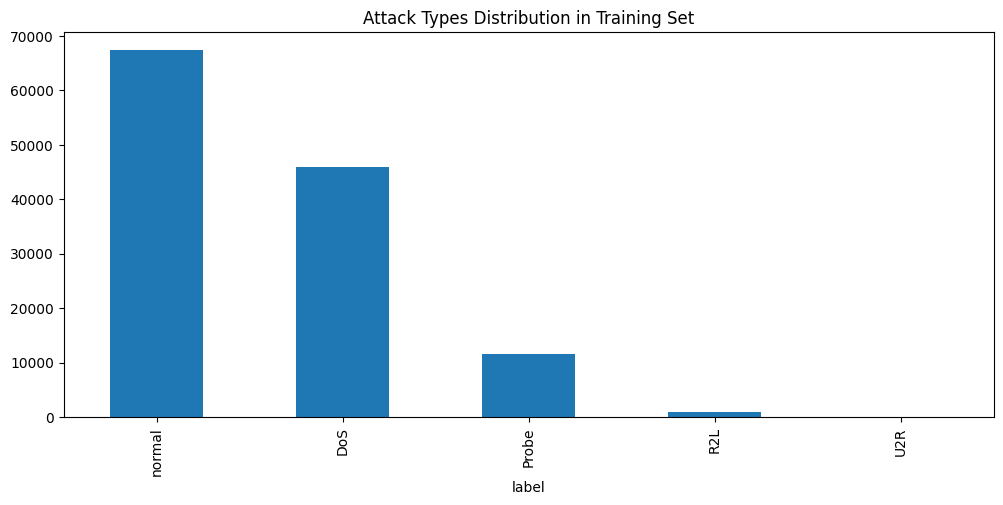

In [11]:
#label distribution after mapping each attack to its attack type
print('Label distribution Training set:')
print(df_train['label'].value_counts())
print()
print('Label distribution Test set:')
print(df_test['label'].value_counts())
print("shape", df_train.shape)



#TODO: ADD
# Visualize label distribution
plt.figure(figsize=(12, 5))
df_train['label'].value_counts().plot(kind='bar',
                                           title='Attack Types Distribution in Training Set')

##1.2: Preprocessing Each Feature Type
There are three feature type: Categorical, binary and numerical. To make our classifier work well, our goal is to put each feature type in the range 0-1. We will accomplish this by using one hot encoding for the cateogirlca features, leave the binary features unchanged and normalize the numerical features using the normal distribution.

In [12]:
categorical_cols = ['protocol_type', 'service', 'flag']
print("\nCategorical columns:", len(categorical_cols))
binary_cols = ["land", "logged_in","root_shell", "su_attempted", "is_hot_login","is_guest_login"]
print(len(binary_cols))
numerical_cols = [col for col in df_train.columns if col not in
                 categorical_cols + binary_cols + ['label', 'difficulty_level']]
print(len(numerical_cols))
assert len(numerical_cols)==32



Categorical columns: 3
6
32


###1.2.1: Transforming categorical features using one hot encoding
We are going to use sklearn's one hot encoder.

In [13]:
# Initialize the encoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit the encoder only on training data
encoder.fit(df_train[categorical_cols])

# Transform both training and test data
train_encoded = encoder.transform(df_train[categorical_cols])
test_encoded = encoder.transform(df_test[categorical_cols])

# Create DataFrames with the encoded features
feature_names = encoder.get_feature_names_out(categorical_cols)
train_encoded_df = pd.DataFrame(train_encoded, columns=feature_names, index=df_train.index)
test_encoded_df = pd.DataFrame(test_encoded, columns=feature_names, index=df_test.index)

# print("index 0",  df_train[0])
# print(df_train.index)

print("\nShape after one-hot encoding (categorical columns):", train_encoded_df.shape)



Shape after one-hot encoding (categorical columns): (125973, 84)


##1.2.2: Normalizing Numerical Features


In [14]:
# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler only on training data
scaler.fit(df_train[numerical_cols])

# Transform both training and test data
train_scaled = scaler.transform(df_train[numerical_cols])
test_scaled = scaler.transform(df_test[numerical_cols])

# Create DataFrames with the scaled features
train_scaled_df = pd.DataFrame(train_scaled, columns=numerical_cols, index=df_train.index)
test_scaled_df = pd.DataFrame(test_scaled, columns=numerical_cols, index=df_test.index)


##1.2.3: Preprocessing Binary features
The binary features will be unchanged.

In [15]:
df_train[binary_cols].head()

,land,logged_in,root_shell,su_attempted,is_hot_login,is_guest_login
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,1,0,0,0,0
4,0,1,0,0,0,0


##1.2.4: Combine all preprocessed features For training data

In [16]:
X_train = pd.concat([
    train_encoded_df,                           # One-hot encoded categorical features
    df_train[binary_cols],  # Binary features (unchanged)
    train_scaled_df                             # Scaled numerical features
], axis=1)

# For test data
X_test = pd.concat([
    test_encoded_df,                           # One-hot encoded categorical features
    df_test[binary_cols],  # Binary features (unchanged)
    test_scaled_df                             # Scaled numerical features
], axis=1)
print("X_train shape", X_train.shape)
print("X_test shape", X_test.shape)

X_train shape (125973, 122)
X_test shape (22544, 122)


##1.2.5 Prepare target values

In [17]:
label_encoder = LabelEncoder()
label_encoder.fit(df_train['label'])

y_train = label_encoder.transform(df_train['label'])
y_test = label_encoder.transform(df_test['label'])

print("y_train shape", y_train.shape)
print("y_test shape", y_test.shape)

y_train shape (125973,)
y_test shape (22544,)


In [18]:
def binarize_features(X, threshold=0.3):
    """Convert continuous features to binary using a threshold."""
    return (X > threshold).astype(int)

# Binarize features if needed for Bernoulli Naive Bayes
X_train_binary = binarize_features(X_train).to_numpy()
X_test_binary = binarize_features(X_test).to_numpy()

print("\nBinarized feature shapes:")
print("X_train_binary shape:", X_train_binary.shape)
print("X_test_binary shape:", X_test_binary.shape)

# print(X_train[0])


Binarized feature shapes:
X_train_binary shape: (125973, 122)
X_test_binary shape: (22544, 122)


#Step2: Implementing Naive Bayes Algorithm

In [19]:
class NaiveBayes(object):
    """Bernoulli Naive Bayes model

    Parameters
    ----------
    n_classes : int
        The number of classes.

    Attributes
    ----------
    n_classes: int
        The number of classes.
    attr_dist: np.ndarray
        2D (n_classes x n_attributes) NumPy array of the attribute distributions
    label_priors: np.nparray
        1D NumPy array of the priors distribution
    """

    def __init__(self, n_classes: int) -> None:
        """
        Constructor for NaiveBayes model with n_classes.
        """
        self.n_classes = n_classes
        self.attr_dist = None
        self.label_priors = None

    def train(
        self, X_train: np.ndarray, y_train: np.ndarray
    ) -> tuple[np.ndarray, np.ndarray]:
        """
        Trains the model using maximum likelihood estimation.

        Parameters
        ----------
        X_train: np.ndarray
            a 2D (n_examples x n_attributes) numpy array
        y_train: np.ndarray
            a 1D (n_examples) numpy array

        Returns
        -------
        tuple[np.ndarray, np.ndarray]
            A tuple consisting of:
                1) a 2D numpy array of the attribute distributions
                2) a 1D numpy array of the priors distribution
        """

        # TODO: calculate and set self.label_priors using class counts (consider smoothing)
        # TODO: calculate and set self.attr_dist (consider smoothing)
        # pass
        n_examples, n_attributes = X_train.shape


        self.attr_dist = np.zeros((self.n_classes, n_attributes))  # Initialize attribute distribution
        self.label_priors = np.zeros(self.n_classes) # Initialize priors

        # count the number of each class
        class_counts = np.zeros(self.n_classes)
        for label in y_train:
            class_counts[label] += 1

        # calculate and set self.label_priors using class counts (consider smoothing)
        self.label_priors = (class_counts + 1) / (n_examples + self.n_classes)

        # calculate and set self.attr_dist (consider smoothing)
        for c in range(self.n_classes):
            class_examples = X_train[y_train == c]

            if len(class_examples) > 0:
                self.attr_dist[c] = (np.sum(class_examples, axis=0) + 1) / (len(class_examples) + 2)

        return self.attr_dist, self.label_priors

    def predict(self, inputs: np.ndarray) -> np.ndarray:
        """Outputs a predicted label for each input in inputs.

        Parameters
        ----------
        inputs: np.ndarray
            a 2D NumPy array containing inputs

        Returns
        -------
        np.ndarray
            a 1D numpy array of predictions
        """

        # pass
        n_examples = inputs.shape[0]
        preds = np.zeros(n_examples, dtype=int)
        # print("preds:", preds)


        for i in range(n_examples):
            example = inputs[i]



            log_probs = np.log(self.label_priors) #log probabilities

            for c in range(self.n_classes):
                presence = example == 1
                absence = example == 0


                log_probs[c] += np.sum(np.log(self.attr_dist[c][presence]))
                log_probs[c] += np.sum(np.log(1 - self.attr_dist[c][absence]))

            # Choose class with highest probability
            preds[i] = np.argmax(log_probs) #class with highest probability
        return preds

    def accuracy(self, X_test: np.ndarray, y_test: np.ndarray) -> float:
        """Outputs the accuracy of the trained model on a given dataset (data).

        Parameters
        ----------
        X_test: np.ndarray
            a 2D numpy array of examples
        y_test: np.ndarray
            a 1D numpy array of labels

        Returns
        -------
        float
            a float number indicating accuracy (between 0 and 1)
        """
        # # TODO: Add your solution code here.
        # pass
        preds = self.predict(X_test)
        correct = np.sum(preds == y_test)
        return correct / len(y_test)




In [20]:
model = NaiveBayes(5)

model.train(X_train_binary, y_train)
nb_preds = model.predict(X_test_binary)
accuracy = accuracy_score(y_test, nb_preds)
precision = precision_score(y_test, nb_preds, average='weighted')
recall = recall_score(y_test, nb_preds, average='weighted')
f1 = f1_score(y_test, nb_preds, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("f1:", f1)

print("------------------------------------------------------------")

print("Train accuracy:")
print(model.accuracy(X_train_binary, y_train))

print("------------------------------------------------------------")

print("Test accuracy:")
print(model.accuracy(X_test_binary, y_test))

print("------------------------------------------------------------")

Accuracy: 0.6869233498935415
Precision: 0.7724345319528632
Recall: 0.6869233498935415
f1: 0.6619203779304744
------------------------------------------------------------
Train accuracy:
0.8540401514610274
------------------------------------------------------------
Test accuracy:
0.6869233498935415
------------------------------------------------------------


#Step3: Implementing K-Nearest Neighbor

In [21]:
#Train KNN
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train)
knn_preds = knn.predict(X_test)

accuracy = accuracy_score(y_test, knn_preds)
precision = precision_score(y_test, knn_preds, average='weighted')
recall = recall_score(y_test, knn_preds, average='weighted')
f1 = f1_score(y_test, knn_preds, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("f1:", f1)


Accuracy: 0.7767476933995742
Precision: 0.8238043882159742
Recall: 0.7767476933995742
f1: 0.7355199707137654


# Step4: Implementing Neural Network

We'll implement a two-layer neural network with improved training and evaluation

In [22]:
def l2_loss(predictions, Y):
    """Computes L2 loss (sum squared loss)"""
    difference = predictions - Y
    return np.sum(difference ** 2)

def sigmoid(a):
    """Sigmoid function with numerical stability"""
    return np.where(a >= 0,
                    1 / (1 + np.exp(-a)),
                    np.exp(a) / (1 + np.exp(a)))

def sigmoid_derivative(a):
    """First derivative of the sigmoid function"""
    sig_a = sigmoid(a)
    return sig_a * (1 - sig_a)

In [48]:
import numpy as np
from scipy.special import softmax
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

class TwoLayerNN:
    """
    Two layer neural network for classification with cross-entropy loss
    and softmax output activation.
    """

    def __init__(
        self,
        input_size,
        hidden_size,
        output_size,
        activation=lambda x: 1/(1+np.exp(-x)),  # Sigmoid
        activation_derivative=lambda x: x*(1-x),  # Sigmoid derivative
        learning_rate=0.01,
        epochs=25,
        batch_size=32
    ):
        self.activation = activation
        self.activation_derivative = activation_derivative
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size

        # Xavier initialization
        self.W01 = np.random.randn(hidden_size, input_size) * np.sqrt(2./(input_size + hidden_size))
        self.b1 = np.zeros(hidden_size)
        self.W12 = np.random.randn(output_size, hidden_size) * np.sqrt(2./(hidden_size + output_size))
        self.b2 = np.zeros(output_size)

    def train(self, X, Y, X_val=None, Y_val=None, print_loss=True):
        train_losses = []
        val_losses = []
        n_samples = X.shape[0]

        # Convert labels to one-hot encoding
        Y_onehot = np.eye(self.output_size)[Y]
        Y_val_onehot = np.eye(self.output_size)[Y_val] if Y_val is not None else None

        for epoch in range(self.epochs):
            # Shuffle data
            indices = np.random.permutation(n_samples)
            X_shuffled = X[indices]
            Y_shuffled = Y_onehot[indices]

            # Mini-batch training
            for i in range(0, n_samples, self.batch_size):
                X_batch = X_shuffled[i:i+self.batch_size]
                Y_batch = Y_shuffled[i:i+self.batch_size]

                # Forward pass
                a1, o1, a2, o2 = self._forward_batch(X_batch)

                # Backward pass
                dW01, db1, dW12, db2 = self._backward_batch(X_batch, Y_batch, a1, o1, a2, o2)

                # Update weights
                self.W01 -= self.learning_rate * dW01
                self.b1 -= self.learning_rate * db1
                self.W12 -= self.learning_rate * dW12
                self.b2 -= self.learning_rate * db2

            # Calculate losses
            train_loss = self._compute_loss(X, Y_onehot)
            train_losses.append(train_loss)

            if X_val is not None and Y_val is not None:
                val_loss = self._compute_loss(X_val, Y_val_onehot)
                val_losses.append(val_loss)
                if print_loss:
                    print(f"Epoch {epoch}: Train Loss {train_loss:.4f} | Val Loss {val_loss:.4f}")
            elif print_loss:
                print(f"Epoch {epoch}: Train Loss {train_loss:.4f}")

        return train_losses, val_losses

    def _forward_batch(self, X):
        a1 = X @ self.W01.T + self.b1
        o1 = self.activation(a1)
        a2 = o1 @ self.W12.T + self.b2
        # Stable softmax
        max_a2 = np.max(a2, axis=1, keepdims=True)
        exp_a2 = np.exp(a2 - max_a2)
        o2 = exp_a2 / np.sum(exp_a2, axis=1, keepdims=True)
        return a1, o1, a2, o2

    def _backward_batch(self, X, Y, a1, o1, a2, o2):
        batch_size = X.shape[0]

        # Output error (cross-entropy derivative)
        error = (o2 - Y) / batch_size

        # Hidden layer gradients
        dW12 = error.T @ o1
        db2 = np.sum(error, axis=0)

        # Propagate error back
        hidden_error = error @ self.W12 * self.activation_derivative(o1)

        # Input layer gradients
        dW01 = hidden_error.T @ X
        db1 = np.sum(hidden_error, axis=0)

        return dW01, db1, dW12, db2

    def _compute_loss(self, X, Y_onehot):
        _, _, _, o2 = self._forward_batch(X)
        # Cross-entropy loss
        return -np.mean(Y_onehot * np.log(o2 + 1e-10))

    def predict(self, X):
        _, _, _, o2 = self._forward_batch(X)
        return np.argmax(o2, axis=1)

    def predict_proba(self, X):
        _, _, _, o2 = self._forward_batch(X)
        return o2
    def evaluate(self, X, y):
        y_pred = self.predict(X)
        print(classification_report(y, y_pred, zero_division=0))
        return y_pred

In [50]:
# Initialize network for 5-class classification
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)
input_size = X_train.shape[1]
hidden_size = 64
output_size = 5

model = TwoLayerNN(
    input_size=input_size,
    hidden_size=hidden_size,
    output_size=output_size,
    learning_rate=0.01,
    epochs=50
)

input_size = X_train.shape[1]
model = TwoLayerNN(
    input_size=input_size,
    hidden_size=128,
    output_size=len(np.unique(y_train)),
    learning_rate=0.001,
    epochs=50,
    batch_size=128
)

# Train with validation
train_loss, val_loss = model.train(X_train.to_numpy(), y_train, X_test.to_numpy(), y_test)

# Evaluate
nn_preds = model.evaluate(X_test.to_numpy(), y_test)
# probs = model.predict_proba(X_test)

Epoch 0: Train Loss 0.1735 | Val Loss 0.2598
Epoch 1: Train Loss 0.1474 | Val Loss 0.2530
Epoch 2: Train Loss 0.1300 | Val Loss 0.2467
Epoch 3: Train Loss 0.1173 | Val Loss 0.2421
Epoch 4: Train Loss 0.1075 | Val Loss 0.2378
Epoch 5: Train Loss 0.0998 | Val Loss 0.2343
Epoch 6: Train Loss 0.0935 | Val Loss 0.2315
Epoch 7: Train Loss 0.0884 | Val Loss 0.2288
Epoch 8: Train Loss 0.0840 | Val Loss 0.2268
Epoch 9: Train Loss 0.0803 | Val Loss 0.2247
Epoch 10: Train Loss 0.0771 | Val Loss 0.2232
Epoch 11: Train Loss 0.0742 | Val Loss 0.2219
Epoch 12: Train Loss 0.0717 | Val Loss 0.2205
Epoch 13: Train Loss 0.0695 | Val Loss 0.2190
Epoch 14: Train Loss 0.0674 | Val Loss 0.2176
Epoch 15: Train Loss 0.0656 | Val Loss 0.2166
Epoch 16: Train Loss 0.0639 | Val Loss 0.2157
Epoch 17: Train Loss 0.0623 | Val Loss 0.2147
Epoch 18: Train Loss 0.0609 | Val Loss 0.2138
Epoch 19: Train Loss 0.0596 | Val Loss 0.2128
Epoch 20: Train Loss 0.0584 | Val Loss 0.2120
Epoch 21: Train Loss 0.0573 | Val Loss 0.211

In [51]:
accuracy = accuracy_score(y_test, nn_preds)
precision = precision_score(y_test, nn_preds, average='weighted')
recall = recall_score(y_test, nn_preds, average='weighted')
f1 = f1_score(y_test, nn_preds, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("f1:", f1)

Accuracy: 0.7350958126330731
Precision: 0.6652705378266424
Recall: 0.7350958126330731
f1: 0.6861213697176538


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#Model Comparison
Let's compare the performance of our implemented models.

Naive Bayes Accuracy: 0.6869


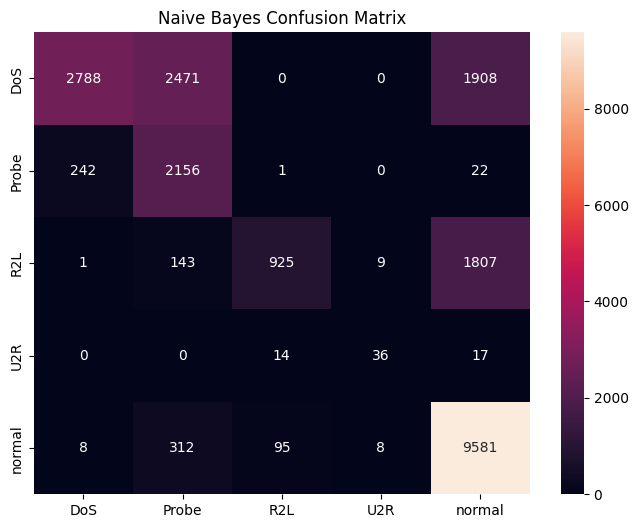

KNN Accuracy: 0.7767


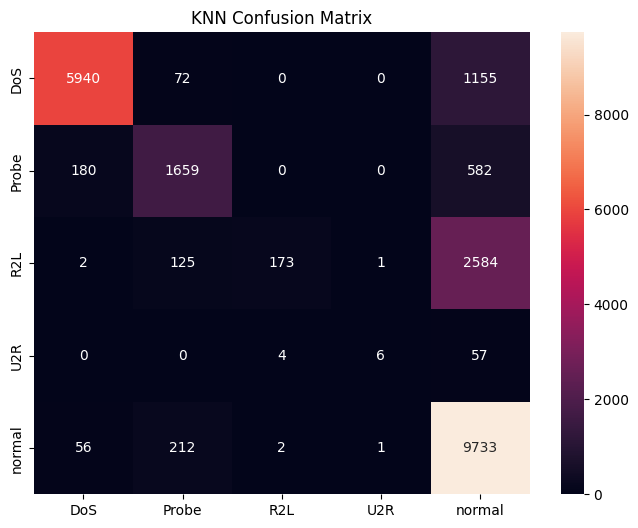

Neural Network Accuracy: 0.7351


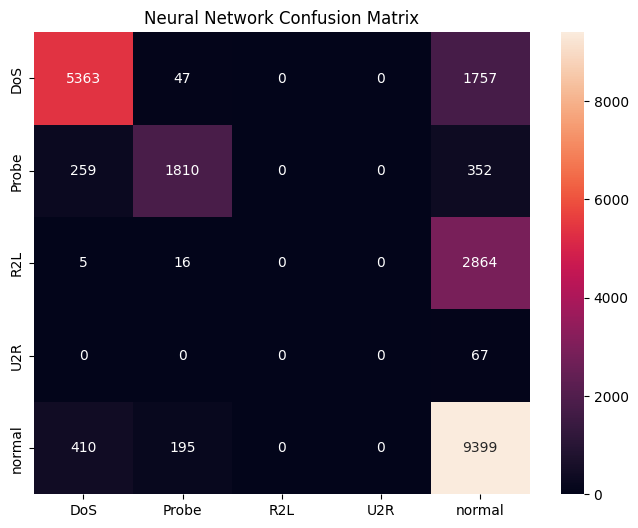

In [52]:


# Evaluation metrics
def evaluate_model(name, preds, y_true=y_test):
    acc = accuracy_score(y_true, preds)
    cm = confusion_matrix(y_true, preds)

    print(f"{name} Accuracy: {acc:.4f}")
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(f'{name} Confusion Matrix')
    plt.show()

evaluate_model('Naive Bayes', nb_preds)
evaluate_model('KNN', knn_preds)
evaluate_model('Neural Network', nn_preds)